## **Importing Dependencies**

In [1]:
import numpy as np
import pandas as pd
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report


## **Mounting Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Making Directory in Drive**

In [3]:
import os

path = "/content/drive/MyDrive/NLP"
os.mkdir(path)

# **Importing Dataset and Unpacking**

In [4]:
import requests 
url = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'
target_path = '/content/drive/MyDrive/NLP/sentiment.zip'

response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(target_path, 'wb') as f:
        f.write(response.raw.read())

In [5]:
import shutil
shutil.unpack_archive("/content/drive/MyDrive/NLP/sentiment.zip","/content/drive/MyDrive/NLP/")

In [6]:
columns = ['target','id','date','flag','user','text']
df = pd.read_csv("/content/drive/MyDrive/NLP/training.1600000.processed.noemoticon.csv",encoding = "ISO-8859-1",names = columns)

In [7]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## **Exploratory Data Analysis**

In [8]:
# Checking for null values and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [9]:
df.shape

(1600000, 6)

In [10]:
#Checking number of unique variables in Target column
df["target"].nunique()

2

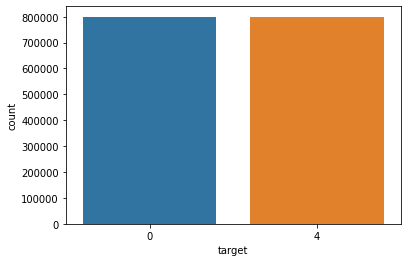

In [11]:
#Checking number of observations for each target variable
sns.countplot(x="target",data = df)

Dataset is balanced so need of imbalanced datset techniques.

## **Data PreProcessing**

In [12]:
df['target'] = df['target'].replace(4,1)

In [13]:
data = df[['text','target']]

In [14]:
data_p = data[data['target']==1]
data_n = data[data['target']==0]

### **Converting to Lowercase**

In [15]:
data['text'] = data['text'].str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### **Removing Stopwords**

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
from nltk.corpus import stopwords
result = set(stopwords.words('english'))

In [18]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in result])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0    @switchfoot http://twitpic.com/2y1zl - awww, t...
1    upset can't update facebook texting it... migh...
2    @kenichan dived many times ball. managed save ...
3                     whole body feels itchy like fire
4    @nationwideclass no, behaving all. i'm mad. he...
Name: text, dtype: object

### **Removing Punctuations**

In [19]:
import string 
punctuations = string.punctuation
def remove_punctuations(text):
  translator = str.maketrans("","",punctuations)
  return text.translate(translator)
data['text'] = data['text'].apply(lambda text: remove_punctuations(text))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### **Remove Repeating Characters**

In [20]:
def remove_repeat_word(text):
  return re.sub(r'(.)1+', r'1', text)
data['text'] = data['text'].apply(lambda text:remove_repeat_word(text))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### **Remove URL**

In [21]:
def cleaning_url(data):
  return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data['text'] = data['text'].apply(lambda x:cleaning_url(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
data.head()

,text,target
0,switchfoot httptwitpiccom21zl a s bummer shou...,0
1,upset cant update facebook texting it might cr...,0
2,kenichan dived many times ball managed save 50...,0
3,whole body feels itchy like fire,0
4,nationwideclass no behaving all im mad here ca...,0


### **Removing Numeric Numbers**

In [23]:
def remove_nums(text):
  return re.sub('[0-9]+', '',text)
data["text"] = data['text'].apply(lambda text:remove_nums(text))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
data.head()

,text,target
0,switchfoot httptwitpiccomzl a s bummer should...,0
1,upset cant update facebook texting it might cr...,0
2,kenichan dived many times ball managed save r...,0
3,whole body feels itchy like fire,0
4,nationwideclass no behaving all im mad here ca...,0


### **Tokenization**

In [25]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
data.head()

,text,target
0,"[switchfoot, httptwitpiccomzl, a, s, bummer, s...",0
1,"[upset, cant, update, facebook, texting, it, m...",0
2,"[kenichan, dived, many, times, ball, managed, ...",0
3,"[whole, body, feels, itchy, like, fire]",0
4,"[nationwideclass, no, behaving, all, im, mad, ...",0


### **Stemming**

In [27]:
st = nltk.PorterStemmer()
def stem_words(data):
  text = [st.stem(word) for word in data]
  return data
data['text'] = data['text'].apply(lambda x: stem_words(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### **Lemmatization**

In [28]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [29]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [30]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))
data['text'].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0    [switchfoot, httptwitpiccomzl, a, s, bummer, s...
1    [upset, cant, update, facebook, texting, it, m...
2    [kenichan, dived, many, times, ball, managed, ...
3              [whole, body, feels, itchy, like, fire]
4    [nationwideclass, no, behaving, all, im, mad, ...
Name: text, dtype: object

In [31]:
data.head()

,text,target
0,"[switchfoot, httptwitpiccomzl, a, s, bummer, s...",0
1,"[upset, cant, update, facebook, texting, it, m...",0
2,"[kenichan, dived, many, times, ball, managed, ...",0
3,"[whole, body, feels, itchy, like, fire]",0
4,"[nationwideclass, no, behaving, all, im, mad, ...",0


### **Visualization using WordCloud**

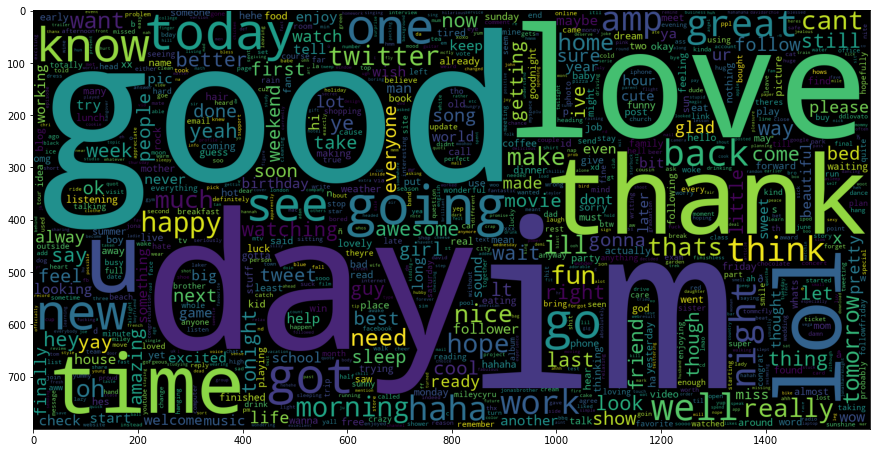

In [32]:
data_pos = data[data['target'] == 1]
plt.figure(figsize = (15,8))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(str(x).replace("'","") for x in data_pos["text"]))
plt.imshow(wc)

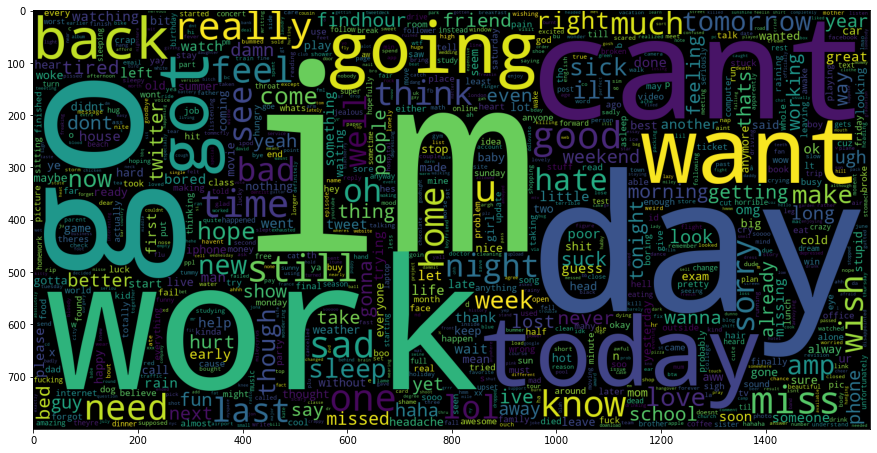

In [33]:
data_neg = data[data['target'] == 0]
plt.figure(figsize = (15,8))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(str(x).replace("'","") for x in data_neg["text"]))
plt.imshow(wc)

In [34]:
X = data.text
y = data.target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1 ,random_state = 22332)

### Transforming Dataset using TF-IDF Vectorizer

In [35]:
X_train

1269670             [got, done, tattin, day, time, go, home]
421565     [jus, got, hair, donelooks, nice, cant, sleepb...
243281     [leaving, cal, amp, half, months, lets, see, h...
1100268    [loves, summer, drives, seminaked, girls, outs...
925169     [velvetropes, alphabetized, mine, took, bloody...
                                 ...                        
1476450    [mistermusik, lol, watching, andy, griffith, o...
31746      [sickness, getting, worse, throat, feels, like...
586854     [mfeige, hope, nothing, serious, doubt, find, ...
615878     [misses, baby, cakes, decided, make, beast, ga...
1156135                     [hangin, mahasarakham, thailand]
Name: text, Length: 1440000, dtype: object

In [36]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(list(X_train.apply(lambda x: ' '.join(x))))
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [37]:
X_train = vectoriser.transform(list(X_train.apply(lambda x: ' '.join(x))))
X_test  = vectoriser.transform(list(X_test.apply(lambda x: ' '.join(x))))

### Function For Model Evaluation

In [38]:
def model_Evaluate(model):
  # Predict values for Test dataset
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# Model Building

              precision    recall  f1-score   support

           0       0.80      0.77      0.78     80039
           1       0.77      0.81      0.79     79961

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



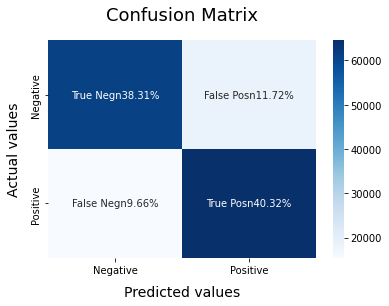

In [39]:
# Model-1
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

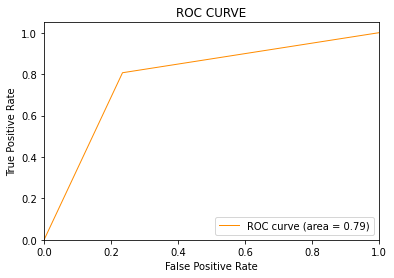

In [40]:
# Plot the ROC-AUC Curve for model-1
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     80039
           1       0.78      0.80      0.79     79961

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



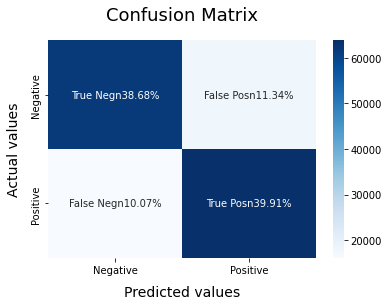

In [41]:
# Model-2
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

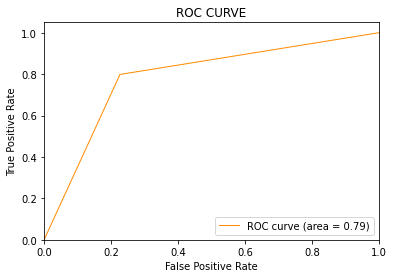

In [42]:
# Plot the ROC-AUC Curve for model-2
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.78      0.80     80039
           1       0.79      0.82      0.80     79961

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000



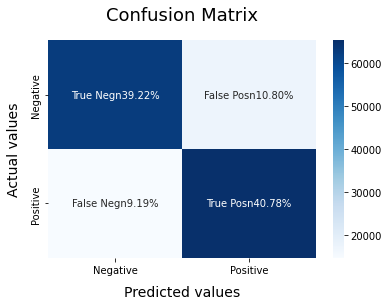

In [43]:
# Model-3
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

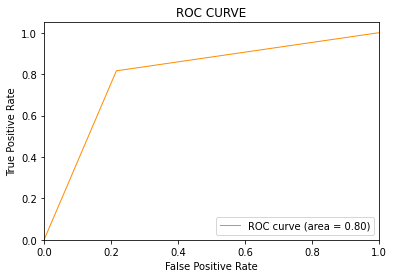

In [44]:
# Plot the ROC-AUC Curve for model-3
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

# Conclusion

In [45]:
'''
Upon evaluating all the models we can conclude that the Logistic Regression is the best model for the above-given dataset.
'''

'\nUpon evaluating all the models we can conclude the following details i.e.\n\nAccuracy: As far as the accuracy of the model is concerned Logistic Regression performs better than SVM which in turn \nperforms better than Bernoulli Naive Bayes.\n\nF1-score: The F1 Scores for class 0 and class 1 are :\n(a) For class 0: Bernoulli Naive Bayes(accuracy = 0.90) < SVM (accuracy =0.91) < Logistic Regression (accuracy = 0.92)\n(b) For class 1: Bernoulli Naive Bayes (accuracy = 0.66) < SVM (accuracy = 0.68) < Logistic Regression (accuracy = 0.69)\n\nAUC Score: All three models have the same ROC-AUC score.\n\nWe, therefore, conclude that the Logistic Regression is the best model for the above-given dataset.\n\nIn our problem statement, Logistic Regression is following the principle of Occam’s Razor which defines that for a particular \nproblem statement if the data has no assumption, then the simplest model works the best. Since our dataset does not have any \nassumptions and Logistic Regression 